In [1]:
import tensorflow as tf

#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.set_visible_devices(physical_devices[1:],'GPU')
tf.executing_eagerly()
print(tf.executing_eagerly())

True


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [3]:
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

import math
import random
import time

import functools

In [4]:
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import datasets, Input, layers, models, Model, losses
from sklearn.preprocessing import MinMaxScaler

In [5]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
from IPython import display
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [6]:
physical_devices = tf.config.list_physical_devices('GPU') 
for gpu_instance in physical_devices: 
    tf.config.experimental.set_memory_growth(gpu_instance, True)

In [7]:
tf.device('/GPU:1')
tf.config.experimental.list_physical_devices('GPU')

strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [8]:
#session=InteractiveSession(config=config)
#session.close()

# Input data stream

In [9]:
num_param = 10
num_time = 800
num_node = 14300
num_var = 1

n_epochs = 20000
batch_size = 10
LR =2e-5
Lv1_latent_dim = 64

alpha = 0

In [10]:
data_save = np.zeros((num_var, num_node,num_param*num_time))
data = np.zeros((num_node,num_param*num_time))


data = pd.read_csv('input_data/FOM_u_sorted.csv', header = None)
print(data.shape)
#print(data)
data_save[0,0:num_node,:]=data.values[0:num_node,:]

"""
del(data)
data = pd.read_csv('input_data/FOM_v_sorted.csv', header = None)
print(data.shape)
data_save[1,0:num_node,:]=data.values[0:num_node,:]
"""
"""
del(data)
data = pd.read_csv('input_data/FOM_x_sorted.csv', header = None)
print(data.shape)
data_save[0,0:num_node,:]=data.values[0:num_node,:]

del(data)
data = pd.read_csv('input_data/FOM_y_sorted.csv', header = None)
print(data.shape)
data_save[0,0:num_node,:]=data.values[0:num_node,:]
del(data)

"""


# Data_save shape : (num_var, num_node, num_time x num_param)

print(data_save.shape)
print(len(np.transpose(data_save)))

data=data_save

(14300, 8000)
(1, 14300, 8000)
8000


In [11]:
# validate
data_save.shape

(1, 14300, 8000)

In [12]:
data_save[0,:,0]

array([-6.67990629e-02, -1.12730000e-04, -5.53449498e-02, ...,
        9.77615776e-05,  1.00696836e-04,  1.32496039e-04])

In [13]:
x_axis = np.linspace(0,num_node,num_node)

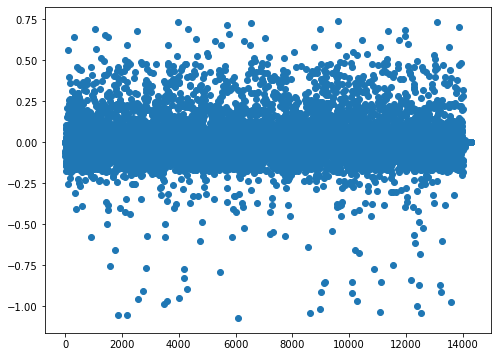

In [14]:
plt.scatter(x_axis, data[0,:,0])

In [15]:
data

array([[[-6.67990629e-02, -6.68890629e-02, -6.69890629e-02, ...,
          8.10709371e-02,  8.42309371e-02,  8.71309371e-02],
        [-1.12730000e-04, -1.12730000e-04, -1.12730000e-04, ...,
          1.57270000e-04,  1.57270000e-04,  1.57270000e-04],
        [-5.53449498e-02, -5.74049498e-02, -5.91949498e-02, ...,
          1.15445050e-01,  9.46250502e-02,  7.57050502e-02],
        ...,
        [ 9.77615776e-05,  1.01973578e-04,  1.05853578e-04, ...,
         -2.23790224e-05, -3.41959224e-05, -4.55196224e-05],
        [ 1.00696836e-04,  1.05035836e-04,  1.09031836e-04, ...,
         -2.30509640e-05, -3.52225640e-05, -4.68861640e-05],
        [ 1.32496039e-04,  1.38205039e-04,  1.43464039e-04, ...,
         -3.03303613e-05, -4.63456613e-05, -6.16927613e-05]]])

## FOM data type : FOM_data = np.array[param, time, node, var]

In [16]:
FOM_data = np.zeros((num_param, num_time, num_node, num_var))

for i in range(num_var):
    for j in range(num_node):
        for k in range(num_param):
            for l in range(num_time):
                temp = l+k*num_time
                #print(l, k, temp)
                FOM_data[k,l,j,i]=data[i,j,temp]
                
FOM_data.shape

(10, 800, 14300, 1)

In [17]:
x_axis

array([0.00000000e+00, 1.00006993e+00, 2.00013987e+00, ...,
       1.42979999e+04, 1.42989999e+04, 1.43000000e+04])

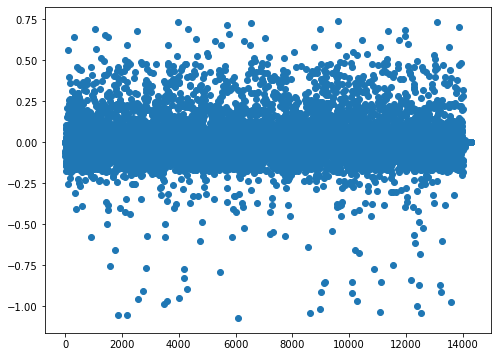

In [18]:
plt.scatter(x_axis, FOM_data[0,0,:,0])

In [19]:
# validate
print(FOM_data[0,0,0,0])
print(FOM_data[1,0,0,0])
print(FOM_data[0,1,0,0])
print(FOM_data[0,0,2,0])

-0.0667990628750013
-0.0514190628750013
-0.0668890628750014
-0.0553449497500003


In [20]:
maximum = np.amax(FOM_data)
minimum = np.amin(FOM_data)
mean = np.mean(FOM_data)
AT = maximum-minimum

In [21]:
print(maximum)
print(minimum)
print(mean)
print(AT)

2.025240682
-3.0420853545825
1.0010634745392302e-15
5.0673260365825


In [22]:
FOM_data = FOM_data-mean
FOM_data = FOM_data/AT

In [23]:
print(np.max(FOM_data))
print(np.min(FOM_data))

0.3996665435338476
-0.6003334564661524


In [24]:
FOM_data.shape

(10, 800, 14300, 1)

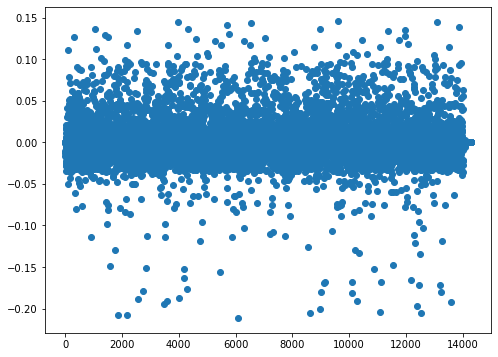

In [25]:
plt.scatter(x_axis, FOM_data[0,0,:,0])

# Level 1, SVAE (spatial VAE)

In [26]:
#Lv1_input = np.zeros((num_param*num_time, num_node, num_var))
# Lv1_input = (num_param x num_time, num_node, num_var)

Lv1_input = FOM_data.reshape(-1, num_node, num_var)
Lv1_input.shape
# Lv1_input is elongated w.r.t. param, 1,2,3,4,..../param change/1,2,3,4,.....

(8000, 14300, 1)

In [27]:
#validate

Lv1_input[200,0,0]
Lv1_input_shape_decoder = Lv1_input.shape[1]

In [28]:
Lv1_input_shape = Lv1_input.shape[1:]

In [29]:
print(Lv1_input.shape)
print(Lv1_input_shape)

(8000, 14300, 1)
(14300, 1)


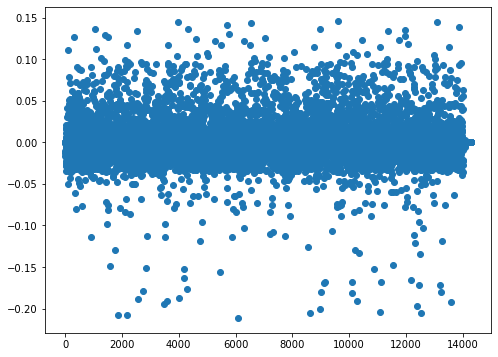

In [30]:
plt.scatter(x_axis, Lv1_input[0,:,0])

# Encoder

In [31]:
def encoder():
    x_input=layers.Input(shape=Lv1_input_shape)
    #x=layers.ZeroPadding1D(2)(x_input)
    
    x=layers.Conv1D(32, 5, strides=1, padding='same', kernel_initializer='glorot_uniform')(x_input)
    #x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)
    
    x=layers.Conv1D(64, 5, strides=1, padding='same', kernel_initializer='glorot_uniform')(x)
    #x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)   
    
    x=layers.Conv1D(128, 5, strides=1, padding='same', kernel_initializer='glorot_uniform')(x)
    #x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)
    
    x=layers.Flatten()(x)
    x=layers.Dense(Lv1_latent_dim)(x)
    
    #mu=layers.Dense(Lv1_latent_dim, kernel_initializer='glorot_uniform')(x)
    #var=layers.Dense(Lv1_latent_dim, kernel_initializer='glorot_uniform')(x)
    #var=layers.Activation(tf.nn.softplus)(var) # var > 0
    
    #eps = tf.random.normal(shape=[Lv1_latent_dim], mean=0.0, stddev=1.0)
    #z = eps * tf.math.sqrt(var) + mu
    
    en_coder = tf.keras.models.Model(x_input, [x], name="ENCODER")
    return en_coder

Encoder=encoder()
Encoder.summary()
#tf.keras.utils.plot_model(Encoder, show_shapes=True)

Model: "ENCODER"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14300, 1)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 14300, 32)         192       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14300, 32)         0         
_________________________________________________________________
dropout (Dropout)            (None, 14300, 32)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 14300, 64)         10304     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14300, 64)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14300, 64)         0   

# Decoder

In [32]:
print(Lv1_latent_dim)
print(Lv1_input_shape_decoder)

64
14300


In [33]:
def decoder():
    z_input=layers.Input(shape=(Lv1_latent_dim))
    
    z=layers.Dense(Lv1_input_shape_decoder*Lv1_latent_dim, kernel_initializer='glorot_uniform')(z_input)
    z=layers.LeakyReLU(alpha=0.3)(z)
    
    z=layers.Reshape([Lv1_input_shape_decoder,Lv1_latent_dim])(z)
        
    z=layers.Conv1DTranspose(128, 4, strides=1, padding='same', kernel_initializer='glorot_uniform')(z)
    #z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)
    
    z=layers.Conv1DTranspose(64, 4, strides=1, padding='same', kernel_initializer='glorot_uniform')(z)
    #z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)
    
    z=layers.Conv1DTranspose(32, 4, strides=1, padding='same', kernel_initializer='glorot_uniform')(z)
    #z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)    
    
    z=layers.Dense(num_var)(z)
    
    
    ## Changed Dense(1, ...) to Dense(num_var, ....)
    
    #z_mu=layers.Dense(num_var, kernel_initializer='glorot_uniform')(z)
    #mu_prime=layers.Activation('tanh')(z_mu)
    
    ## Changed Dense(1, ...) to Dense(num_var, ....)
    
    #z_var=layers.Dense(num_var, kernel_initializer='glorot_uniform')(z)
    #var_prime=layers.Activation(tf.nn.softplus)(z_var) # var > 0
    
    ## I guess the 
    
    
    de_coder = tf.keras.models.Model(z_input, [z], name="DECODER")
    return de_coder

Decoder=decoder()
Decoder.summary()
#tf.keras.utils.plot_model(Decoder, show_shapes=True)

Model: "DECODER"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 915200)            59488000  
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 915200)            0         
_________________________________________________________________
reshape (Reshape)            (None, 14300, 64)         0         
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 14300, 128)        32896     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14300, 128)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14300, 128)        0   

# loss computation

In [34]:
def compute_loss(real_img, fake_img):
    
    reconstruction_error = tf.math.reduce_mean(tf.math.reduce_sum(tf.math.square(real_img) + tf.math.square(fake_img)))
    
    
    loss = reconstruction_error
    
    return loss

# VAE

In [35]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, ENCODER, DECODER):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.ENCODER = ENCODER
        self.DECODER = DECODER
        
    def compile(self, opt, loss):
        super(VAE, self).compile()
        self.opt = opt
        self.loss = loss

    def train_step(self, real_img):
        if isinstance(data, tuple):
            real_img = real_img[0]
            
        with tf.GradientTape() as tape:
            # encoding
            latent_space = self.ENCODER(real_img, training=True)
            
            # decoding
            fake_img = self.DECODER(latent_space, training=True)
            
            # loss calculation
            loss = self.loss(real_img, fake_img)
            
        gradients = tape.gradient(loss, self.trainable_variables)
        self.opt.apply_gradients(zip(gradients, self.trainable_variables))
        return {"loss": loss}


# Save Model

In [36]:
class SaveModel(tf.keras.callbacks.Callback):
    def __init__(self, num_iter=n_epochs, latent_dim=Lv1_latent_dim):
        self.num_iter = num_iter
        self.latent_dim = Lv1_latent_dim
        
    def on_epoch_end(self, epoch, logs=None):
        if((epoch+1)%1000==0):
            if((epoch+1)%1000==0):          
                filename1 = 'test_constrained_ae/decoder_%dbatchnorm.h5' % (epoch+1)
                filename2 = 'test_constrained_ae/encoder_%dbatchnorm.h5' % (epoch+1)
                
                Decoder.save(filename1)
                Encoder.save(filename2)

In [37]:
print(Lv1_input.shape)
print(type(Lv1_input))

(8000, 14300, 1)
<class 'numpy.ndarray'>


# Warm up

In [38]:
beta = K.variable(0.)
N_t = int(n_epochs * 0.25)

class WarmUp(tf.keras.callbacks.Callback):
    def __init__(self, beta):
        self.beta = beta
        
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < N_t:
            K.set_value(self.beta, epoch / N_t)
        else:
            K.set_value(self.beta, 1)


In [39]:
opt = tf.keras.optimizers.Adam(learning_rate=LR, beta_1=0.5, beta_2=0.99)

cbk1 = SaveModel(num_iter=n_epochs,latent_dim=Lv1_latent_dim)
cbk2 = WarmUp(beta)

#with strategy.scope():
vae = VAE(latent_dim=Lv1_latent_dim, ENCODER=Encoder, DECODER=Decoder)
vae.compile(opt=opt, loss=losses.MeanSquaredError())

start = time.time()
vae.fit(Lv1_input, batch_size=batch_size, epochs=n_epochs, callbacks=[cbk1, cbk2])
end = time.time()

print(end-start)

Epoch 1/20000
800/800 [==============================] - 32s 35ms/step - loss: 5.8291e-04
Epoch 2/20000
800/800 [==============================] - 81s 101ms/step - loss: 1.5327e-04
Epoch 3/20000
800/800 [==============================] - 96s 120ms/step - loss: 1.1102e-04
Epoch 4/20000
800/800 [==============================] - 97s 121ms/step - loss: 9.1544e-05
Epoch 5/20000
800/800 [==============================] - 97s 121ms/step - loss: 8.1612e-05
Epoch 6/20000
800/800 [==============================] - 97s 121ms/step - loss: 7.4731e-05
Epoch 7/20000
800/800 [==============================] - 97s 121ms/step - loss: 7.0143e-05
Epoch 8/20000
800/800 [==============================] - 97s 121ms/step - loss: 6.6977e-05
Epoch 9/20000
800/800 [==============================] - 97s 121ms/step - loss: 6.4578e-05
Epoch 10/20000
800/800 [==============================] - 83s 104ms/step - loss: 6.2300e-05
Epoch 11/20000
800/800 [==============================] - 73s 92ms/step - loss: 6.0599e-05

KeyboardInterrupt: 

# Acquire latent vectors